# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть».  
Нужно решить, где бурить новую скважину.  

Вам предоставлены пробы нефти в трёх регионах:  
в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.  
Постройте модель машинного обучения,  
которая поможет определить регион, где добыча принесёт наибольшую прибыль.  

Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;  
- Строят модель и оценивают объём запасов;  
  Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).  
- Выбирают месторождения с самым высокими оценками значений.  
  Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;  
- Прибыль равна суммарной прибыли отобранных месторождений.  

## Загрузка и подготовка данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
geo_data_1 = pd.read_csv('geo_data_0.csv')
geo_data_2 = pd.read_csv('geo_data_1.csv')
geo_data_3 = pd.read_csv('geo_data_2.csv')

### Общая информация
Обозначения столбцов:
* `id` — уникальный идентификатор скважины;
* `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
* `product` — объём запасов в скважине (тыс. баррелей).

In [3]:
def df_info(df):
    name =[x for x in globals() if globals()[x] is df][0]
    dubl = df.duplicated().sum()
    zero_oil = df.query('product == 0')['id'].count()
    uniq_product = len(df['product'].unique())
    display(f">>> {name} <<<")
    display(df.head())
    df.info()
    if dubl:
        print(f'\nКоличество дубликатов: {dubl}')
    else:
        print(f'\nДубликатов нет')
    print(f'Количество скважин с нулевым объёмом запасов: {zero_oil}')
    print(f'Количество уникальных значений объёма запасов: {uniq_product}')
    display(df.describe())
    print('\n——————————————————————————————————————————————————————————————————')

In [4]:
df_info(geo_data_1)
df_info(geo_data_2)
df_info(geo_data_3)

'>>> geo_data_1 <<<'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Дубликатов нет
Количество скважин с нулевым объёмом запасов: 1
Количество уникальных значений объёма запасов: 100000


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



——————————————————————————————————————————————————————————————————


'>>> geo_data_2 <<<'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Дубликатов нет
Количество скважин с нулевым объёмом запасов: 8235
Количество уникальных значений объёма запасов: 12


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



——————————————————————————————————————————————————————————————————


'>>> geo_data_3 <<<'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Дубликатов нет
Количество скважин с нулевым объёмом запасов: 1
Количество уникальных значений объёма запасов: 100000


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838



——————————————————————————————————————————————————————————————————


### Столбец `id`
Столбцы id не содержат пользы для обучения моделей, можно удалить.

In [5]:
geo_data_1 = geo_data_1.drop(['id'], axis=1)
geo_data_2 = geo_data_2.drop(['id'], axis=1)
geo_data_3 = geo_data_3.drop(['id'], axis=1)

### Распределение по объёму запасов

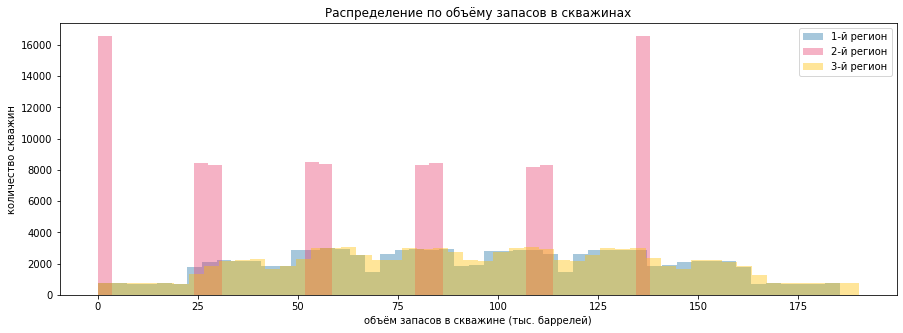

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(15, 5))
sns.distplot(geo_data_1['product'], kde=False, color='#2274A5')
sns.distplot(geo_data_2['product'], kde=False, color='#E83F6F')
sns.distplot(geo_data_3['product'], kde=False, color='#FFBF00')
plt.legend(['1-й регион', '2-й регион', '3-й регион'])
plt.xlabel('объём запасов в скважине (тыс. баррелей)')
plt.ylabel('количество скважин')
plt.title('Распределение по объёму запасов в скважинах')
plt.show()

***
### [Промежуточный вывод по первому пункту](#1conclusion)

* Дубликаты в данных отутствуют.
* Столбцы `id` не содержат пользы для обучения моделей, можно удалить.
* В втором регионе `geo_data_2` 8235 скважин с нулевым объёмом запасов.  
  При этом всего 11 уникальных значений объёма выше нуля.  
  Скорее всего, данные нарушены.  
  При этом уникальные значения совпадают вплоть до восьмого знака после запятой.  
  Но так как дубликатов нет, удалять строки не буду.  
  Замена на среднее или медианное значение, на мой взгляд, нарушит общую картину.<br><br>
***

## Обучение и проверка модели

In [7]:
def predictions_by_region(df, region_name): 
    features = df.drop(['product'], axis=1)
    target = df['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345
    )
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)

    model = LinearRegression(normalize=False)
    model.fit(features_train, target_train)
    predicted_valid = pd.Series(model.predict(features_valid))
    mse = mean_squared_error(target_valid, predicted_valid)
    rmse = mse ** 0.5

    mean_product = target.mean()
    mean_predicted = predicted_valid.mean()

    print(f'>>> {region_name} <<<')
    print(f'Среднеквадратическая ошибка (RMSE) модели: {rmse:.2f}')
    print(f'Средний предсказанный объём запасов в скважине (тыс. баррелей): {mean_predicted:.2f}\n')
    
    target_valid = target_valid.reset_index(drop=True)
    return predicted_valid, target_valid

In [8]:
predicted_valid_1, target_valid_1 = predictions_by_region(geo_data_1, 'Первый регион')
predicted_valid_2, target_valid_2 = predictions_by_region(geo_data_2, 'Второй регион')
predicted_valid_3, target_valid_3 = predictions_by_region(geo_data_3, 'Третий регион')
predictions_dict = {
    'Первый регион': (predicted_valid_1, target_valid_1),
    'Второй регион': (predicted_valid_2, target_valid_2),
    'Третий регион': (predicted_valid_3, target_valid_3),
}

>>> Первый регион <<<
Среднеквадратическая ошибка (RMSE) модели: 37.58
Средний предсказанный объём запасов в скважине (тыс. баррелей): 92.59

>>> Второй регион <<<
Среднеквадратическая ошибка (RMSE) модели: 0.89
Средний предсказанный объём запасов в скважине (тыс. баррелей): 68.73

>>> Третий регион <<<
Среднеквадратическая ошибка (RMSE) модели: 40.03
Средний предсказанный объём запасов в скважине (тыс. баррелей): 94.97



***
### [Промежуточный вывод по второму пункту]()

* Лучший показатель среднеквадратической ошибки у второго региона.  
  Данные по этому региону, скорее всего, нарушены.  
  Нельзя с уверенностью относится к показателю RMSE.
* Показатели RMSE первого и третьего регионов близки и равны примерно `38.81`.
* Средний предсказанный объём запасов у второго региона меньше всего.  
  Данные по этому региону, скорее всего, нарушены.  
* Средний предсказанный объём запасов у второго региона меньше всего.
* Средние предсказанные объёмы запасов первого и третьего регионов близки и равны примерно `93.78` тыс. баррелей.<br><br>
***

## Подготовка к расчёту прибыли

Условия задачи:
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода.  
  Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%.  
  Среди них выбирают регион с наибольшей средней прибылью.

In [9]:
BUDGET = 10e9
WELLS_TARGET = 200
WELLS_POOL = 500
PRODUCT_REVENUE = 450e3
LOSS_PROBABILITY = 0.025
well_cost = BUDGET / WELLS_TARGET
product_target = well_cost / PRODUCT_REVENUE 

In [10]:
print(f'Стоимость разработки одной точки: {well_cost / 1e6:.0f} млн. руб.')
print(f'Порог безубыточности одной точки: {product_target:.2f} тыс. баррелей')

Стоимость разработки одной точки: 50 млн. руб.
Порог безубыточности одной точки: 111.11 тыс. баррелей


***
### [Промежуточный вывод по третьему пункту]()

* Порог безубыточной добычи (`111.11`) выше средних показателей каждого региона (примерно `93.78`).<br><br>
***

## Расчёт прибыли и рисков 

Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [11]:
def profit_prediction(predictions, target):
    data = pd.concat([predictions, target], axis=1)
    data.columns = ['predictions', 'target']
    data = data.sort_values(by='predictions', ascending=False)[:WELLS_TARGET]
    profit = (data['target'].sum() * PRODUCT_REVENUE) - BUDGET
    return profit


def profit_assessment(predictions, target):
    state = np.random.RandomState(12345)
    profits = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        profit = profit_prediction(predictions_subsample, target_subsample)
        profits.append(profit)
    
    profits = pd.Series(profits)
    lower = profits.quantile(0.025)
    upper = profits.quantile(0.975)
    mean = profits.mean()
    losses_probability = (profits < 0).mean()
    
    print(f'Средняя прибыль: {mean / 1e6:.1f} млн. руб.')
    print(f'95%-й доверительный интервал: {lower / 1e6:.0f} – {upper / 1e6:.0f}  млн. руб.')
    print(f'Риск убытков: {losses_probability:.1%}\n')

In [12]:
profit_region_1 = profit_prediction(predicted_valid_1, target_valid_1)
profit_region_2 = profit_prediction(predicted_valid_2, target_valid_2)
profit_region_3 = profit_prediction(predicted_valid_3, target_valid_3)
for i, profit in enumerate([profit_region_1, profit_region_2, profit_region_3]):
    print(f'Общая прибыль для {i + 1}-го региона: {profit / 1e9:.3f} млрд. руб.')

Общая прибыль для 1-го региона: 3.321 млрд. руб.
Общая прибыль для 2-го региона: 2.415 млрд. руб.
Общая прибыль для 3-го региона: 2.710 млрд. руб.


In [13]:
for name, data in predictions_dict.items():
    print(f'>>> {name} <<<')
    profit_assessment(data[0], data[1])

>>> Первый регион <<<
Средняя прибыль: 396.2 млн. руб.
95%-й доверительный интервал: -111 – 910  млн. руб.
Риск убытков: 6.9%

>>> Второй регион <<<
Средняя прибыль: 456.0 млн. руб.
95%-й доверительный интервал: 34 – 852  млн. руб.
Риск убытков: 1.5%

>>> Третий регион <<<
Средняя прибыль: 404.4 млн. руб.
95%-й доверительный интервал: -163 – 950  млн. руб.
Риск убытков: 7.6%



***
## [Общий вывод]()

Только второй регион подходит под условия задачи — риск убытков менее 2.5%.  
Риск убытков во втором регионе — `1.5%`.  
Он же является регионом с наибольшей средней прибылью — `456 млн. руб.`  
Но исходя из [выводов первого пункта](https://github.com/Lidiya-cutie/Diplom_SF/blob/89a5c8c9ad2bc9bee5d64fb4dfc040c6b81d3a49//#1conclusion),  
данные по объёму запасов второго региона:  
  - имеют много (8%) нулевых значений;  
  - 11 уникальных значений объёма запасов выше нуля;  
  - уникальные значения совпадают вплоть до восьмого знака после запятой.  

Высока вероятность того, что данные по объёму запасов нарушены и им нельзя доверять.  
Рекомендуется перепроверить источник данных по второму региону.<br><br>
***